# VQE for H2 Molecule

###  Preparing Hamiltonian of H2 Molecule
This Hamiltonina obtained from [Electronic Structure documents of Qiskit-Nature](https://qiskit.org/documentation/nature/tutorials/01_electronic_structure.html) that is prepared based on `sto3g` basis set, `PYSCF` driver, `second_quantization` method, and `Jordan-Wigner` mapping method.

As we used `sto3g` basis set, the number of atomic orbitals is as follows:

H: 1s = 1 <br>
H: 1s = 1

You can get the number of atomic orbitals for each element in each basis set [here](http://www.basissetexchange.org/).<br>
The number of Molecular orbitals is: 1+1=2. <br>
The number of Spin orbitals is equal to the number of Molecular orbitals multiplied by two: 2*2=4. <br>
The number of qubits is equal to the number of Spin orbitals: 4.

In [1]:
from qiskit.opflow import I, X, Z, Y

H2_operator = (-0.8105479805373279 * I^I^I^I)+\
                (+ 0.1721839326191554 * I^I^I^Z)+\
                (- 0.22575349222402372 * I^I^Z^I)+\
                (+ 0.17218393261915543 * I^Z^I^I)+\
                (- 0.2257534922240237 * Z^I^I^I)+\
                (+ 0.12091263261776627 * I^I^Z^Z)+\
                (+ 0.16892753870087907 * I^Z^I^Z)+\
                (+ 0.045232799946057826 * Y^Y^Y^Y)+\
                (+ 0.045232799946057826 * X^X^Y^Y)+\
                (+ 0.045232799946057826 * Y^Y^X^X)+\
                (+ 0.045232799946057826 * X^X^X^X)+\
                (+ 0.1661454325638241 * Z^I^I^Z)+\
                (+ 0.1661454325638241 * I^Z^Z^I)+\
                (+ 0.17464343068300453 * Z^I^Z^I)+\
                (+ 0.12091263261776627 * Z^Z^I^I)

print("Number of qubits:", H2_operator.num_qubits)

Number of qubits: 4


ground state? <br>
eigenvalue? <br>
shroginger eq?

As there are only 2 qubits, it's easily tractable classically. We will use `NumPyMinimumEigensolver` to compute a reference value so we can compare later the results.



In [2]:
from qiskit.algorithms import NumPyMinimumEigensolver
numpy1 = NumPyMinimumEigensolver()
result1 = numpy1.compute_minimum_eigenvalue(operator=H2_operator)
ref_value = result1.eigenvalue.real
print("Reference value:",ref_value)

Reference value: -1.8572750302023873


explanation of vqe? hybrid algorithm <br>
photo from readme ?

### Ansatz
Explanation about ansatz ???

In [3]:
from typing import List
import numpy as np
import qutip as qt
from qiskit.extensions import HamiltonianGate
from qiskit import QuantumCircuit, QuantumRegister, Aer, execute
from qiskit.providers.aer import QasmSimulator
from qiskit.quantum_info import Operator

In [4]:
def create_zz_hamiltonian(num_qubits: int, connectivity: List[List[int]],
                              h_coeffs: List[float]) -> np.ndarray:
    """Creates a global Hamiltonian consisting of a sum of one (g * Z^i.Z^j) term per device connection.

    Args:
        num_qubits (int): number of qubits of the Hamiltonian
        connectivity (List[List[int]]): connectivity of the device
        h_coeffs (List[float]): list of coefficients of each ZZ term

    Returns:
        np.ndarray: tensored Hamiltonian
    """
    
    dim = 2 ** num_qubits
    num_connections = len(connectivity)
    zz_hamiltonian = np.zeros([dim, dim], dtype=np.complex128)

    # create a matrix that is the sum of ZZ operators on all connected qubits,
    # tensored with the identity
    for c in range(num_connections):
        ops_to_tensor = [qt.identity(2)] * num_qubits
        ops_to_tensor[connectivity[c][0]] = qt.sigmaz()
        ops_to_tensor[connectivity[c][1]] = qt.sigmaz()
        zz_hamiltonian += h_coeffs[c] * np.array(qt.tensor(ops_to_tensor))

    return zz_hamiltonian

In [5]:
num_qubits = 4
hamiltonian = create_zz_hamiltonian(num_qubits, [[0, 1],[1,2],[2,3]], [1.,1.,1.,1.]) 
analog_block = HamiltonianGate(data=hamiltonian, time=2) 

In [6]:
qr = QuantumRegister(num_qubits)
circ = QuantumCircuit(qr)

### Initialization
hartree fock method ??? <br>
explanation ???

In [7]:
#from qiskit_nature.converters.second_quantization import QubitConverter
#from qiskit_nature.mappers.second_quantization import JordanWignerMapper
#qubit_converter = QubitConverter(mapper=JordanWignerMapper())

In [8]:
#from qiskit_nature.circuit.library import HartreeFock
#init_state = HartreeFock(num_spin_orbitals=4, 
#                         num_particles=2,
#                         qubit_converter=qubit_converter)
#init_state.barrier()
#init_state.draw()

In [9]:
#initialization
circ.x(0)
circ.h(1)
circ.barrier()

### Parametrizing the circuit
for solving molecule hamiltonian, we use U gate, why??? <br>
only teta? phi and lambda to zero, why ??

In [10]:
# adding parametrized u gates at the first and last part
from qiskit.circuit import Parameter, ParameterVector

p = ParameterVector('θ', 2*num_qubits)


counter=0
for i in range(num_qubits):
    circ.ry(p[counter],i)
    counter+=1
circ.barrier()

for i in range(num_qubits):
    circ.rz(p[counter],i)
    counter+=1
circ.unitary(analog_block, [qr[0], qr[1], qr[2], qr[3]], label='analog block')
circ.draw()

┌───┐ ░ ┌──────────┐ ░ ┌──────────┐┌───────────────┐
q0_0: ┤ X ├─░─┤ Ry(θ[0]) ├─░─┤ Rz(θ[4]) ├┤0              ├
      ├───┤ ░ ├──────────┤ ░ ├──────────┤│               │
q0_1: ┤ H ├─░─┤ Ry(θ[1]) ├─░─┤ Rz(θ[5]) ├┤1              ├
      └───┘ ░ ├──────────┤ ░ ├──────────┤│  analog block │
q0_2: ──────░─┤ Ry(θ[2]) ├─░─┤ Rz(θ[6]) ├┤2              ├
            ░ ├──────────┤ ░ ├──────────┤│               │
q0_3: ──────░─┤ Ry(θ[3]) ├─░─┤ Rz(θ[7]) ├┤3              ├
            ░ └──────────┘ ░ └──────────┘└───────────────┘

In [11]:
# ansatz
ansatz = circ

### Setting other inputs of VQE

In [12]:
# random seed
from qiskit.utils import algorithm_globals
seed = 170
iterations = 125
algorithm_globals.random_seed = seed

In [13]:
# Quantum Instance
from qiskit import Aer
from qiskit.utils import QuantumInstance
backend = Aer.get_backend('aer_simulator')
qi = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed) 

In [14]:
# callback function
counts = []
values = []
def store_intermediate_result(eval_count, parameters, mean, std):
    counts.append(eval_count)
    values.append(mean)

In [15]:
# optimization
from qiskit.algorithms.optimizers import SPSA
spsa = SPSA(maxiter=iterations)

### VQE

In [16]:
# VQE
from qiskit.algorithms import VQE
vqe = VQE(ansatz, optimizer=spsa, callback=store_intermediate_result, quantum_instance=qi)
result = vqe.compute_minimum_eigenvalue(operator=H2_operator)


In [17]:
print("VQE on Aer qasm simulator (no noise):",result.eigenvalue.real)
print("Delta from reference energy value is:",result.eigenvalue.real - ref_value)

VQE on Aer qasm simulator (no noise): -1.8297631785003283
Delta from reference energy value is: 0.027511851702058943


### Plot

We captured the energy values above during the convergence so we can see what went on in the graph below.

Text(0.5, 1.0, 'Convergence with no noise')

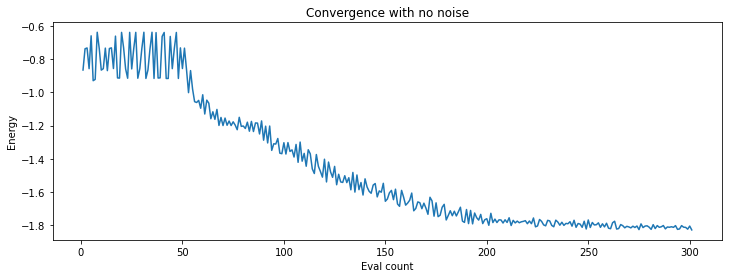

In [18]:
import pylab
pylab.rcParams['figure.figsize'] = (12, 4) # ????
pylab.plot(counts, values)
pylab.xlabel('Eval count')
pylab.ylabel('Energy')
pylab.title('Convergence with no noise') # Title